In [1]:
google_colab = False

# Google Colab用事前準備

In [2]:
# install
try:
    import binarybrain as bb
except:
    if google_colab and False:
        !pip install pybind11
        %cd /content
        !nvcc -V
        !sudo rm -fr BinaryBrain
        !rm -fr BinaryBrain
        !git clone --recursive -b ver3_develop https://github.com/ryuz/BinaryBrain.git
        %cd /content/BinaryBrain/python
        !sh copy_src.sh
        !python3 setup.py build
        !python3 setup.py develop

        import binarybrain as bb

In [3]:
# mount
if google_colab:
  from google.colab import drive 
  drive.mount('/content/drive')
  %cd /content/drive/My Drive/git-work/BinaryBrain_ver3_develop/tests/python

In [4]:
device = 0

import binarybrain as bb

import importlib
importlib.reload(bb)

bb.set_device(device)
#prop = bb.get_device_properties(device)
#print(prop)

# メインコード

In [5]:
import binarybrain as bb
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import OrderedDict

In [6]:
def make_test_image(src_x, src_t):
    dst_x = np.ndarray((len(src_x),  1, 28, 28), dtype=np.float32)
    dst_t = np.ndarray((len(src_x), 11, 28, 28), dtype=np.float32)
    for i in range(len(src_x)):
        x_img = src_x[i].copy()
        t_img = np.zeros((11, 28*28), dtype=np.float32)
        mask0 = x_img <= 0.5
        mask1 = x_img > 0.5
        for j in range(10):
          t_img[j,mask1] = src_t[i][j]
        t_img[10,mask0] = 1.0
        dst_x[i] = x_img.reshape(1, 28, 28)
        dst_t[i] = t_img.reshape(11, 28, 28)
    return dst_x, dst_t

In [7]:
def make_test_data(src_x, src_t):
    x, t = make_test_image(src_x, src_t)

    dst_x = np.ndarray((len(src_x) // 4,  1*56*56), dtype=np.float32)
    dst_t = np.ndarray((len(src_x) // 4, 11*56*56), dtype=np.float32)
    for i in range(len(x) // 4):
        x_img = np.hstack((np.dstack((x[i*4+0], x[i*4+1])), np.dstack((x[i*4+2], x[i*4+3]))))
        t_img = np.hstack((np.dstack((t[i*4+0], t[i*4+1])), np.dstack((t[i*4+2], t[i*4+3]))))
        dst_x[i] = x_img.reshape(-1)
        dst_t[i] = t_img.reshape(-1)
    return dst_x, dst_t

In [8]:
# load MNIST data
td = bb.load_mnist()

td['x_train'], td['t_train'] = make_test_data(td['x_train'], td['t_train'])
td['x_test'],  td['t_test']  = make_test_data(td['x_test'], td['t_test'])
td['x_shape'] = [56, 56, 1]
td['t_shape'] = [56, 56, 11]

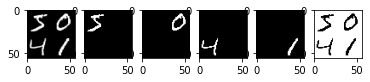

In [9]:
plt.subplot(161)
plt.imshow(td['x_train'][0].reshape(56, 56), 'gray')
plt.subplot(162)
plt.imshow(td['t_train'][0].reshape(11, 56, 56)[5], 'gray')
plt.subplot(163)
plt.imshow(td['t_train'][0].reshape(11, 56, 56)[0], 'gray')
plt.subplot(164)
plt.imshow(td['t_train'][0].reshape(11, 56, 56)[4], 'gray')
plt.subplot(165)
plt.imshow(td['t_train'][0].reshape(11, 56, 56)[1], 'gray')
plt.subplot(166)
plt.imshow(td['t_train'][0].reshape(11, 56, 56)[10], 'gray')

In [10]:
color_table = [
    [0xe6, 0x00, 0x12],  # 0
    [0x92, 0x07, 0x83],  # 1
    [0x1d, 0x20, 0x88],  # 2
    [0x00, 0x68, 0xb7],  # 3
    [0x00, 0xa0, 0xe9],  # 4
    [0x00, 0x9e, 0x96],  # 5
    [0x00, 0x99, 0x44],  # 6
    [0x8f, 0xc3, 0x1f],  # 7
    [0xff, 0xf1, 0x00],  # 8
    [0xf3, 0x98, 0x00],  # 9
    [0x00, 0x00, 0x00],  # BGC
]

def frame_to_image(frame):
    idx_img = np.argmax(frame, axis=0)
    rgb_img = np.ndarray((idx_img.shape[0], idx_img.shape[1], 3), dtype=np.uint8)
    for y in range(idx_img.shape[1]):
        for x in range(idx_img.shape[0]):
            rgb_img[y][x] = color_table[idx_img[y][x]]
    return rgb_img

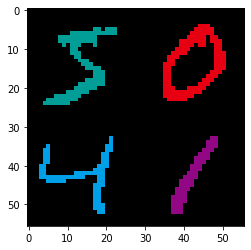

In [11]:
plt.imshow(frame_to_image(td['t_train'][0].reshape(11, 56, 56)))

# ネットワーク構築

In [12]:
data_path = 'MnistSegSparseCnnBinDistillation'
os.makedirs(data_path, exist_ok=True)
network_name = 'mnist-seg-sparse-cnn-bin-distillation'

ref_affine_list = []
ref_norm_list   = []
target_lut_list = []

def clear_list():
    ref_affine_list.clear()
    ref_norm_list.clear()
    target_lut_list.clear()

def save_model_list(model_list, name, path='.'):
    os.makedirs(os.path.join(data_path, path), exist_ok=True)
    for i, model in enumerate(model_list):
        model.save_json(os.path.join(data_path, path, '%s_%d.json' % (name, i)))

def load_model_list(model_list, name, path='.'):
    for i, model in enumerate(model_list):
        filename = os.path.join(data_path, path, '%s_%d.json' % (name, i))
        if not os.path.exists(filename):
            return False
        model.load_json(filename)
    return True

def save_all_model(path='.'):
    save_model_list(ref_affine_list, 'ref_affine',    path)
    save_model_list(ref_norm_list,   'ref_norm_list', path)
    save_model_list(target_lut_list, 'target_lut',    path)
    
def load_all_model(path='.'):
    if not load_model_list(ref_affine_list, 'ref_affine',    path): return False
    if not load_model_list(ref_norm_list,   'ref_norm_list', path): return False
    if not load_model_list(target_lut_list, 'target_lut',    path): return False
    return True

def make_common_layer(model):
    layer = {}
    layer['type']   = 'common'
    layer['select'] = 'common'
    layer['common'] = model
    return layer    

def make_cnv_layer(ch_size, w=3, h=3, lut_size=2, connection='random', padding='same'):
    # setup infomation
    layer = {}
    layer['type']            = 'convolution'
    layer['select']          = 'ref'
    layer['connection']      = connection
    layer['target_lut_size'] = 2
    
    layer['ref_affine'] = bb.DenseAffine.create([ch_size])
    layer['ref_norm']   = bb.BatchNormalization.create()
    layer['ref_act']    = bb.BinarizeBit.create()
    
    layer['lut_size'] = lut_size
    for i in range(lut_size):
        layer['target_lut%d' % i] = bb.SparseLut6Bit.create([ch_size*(6**i)])
    
    # save
    ref_affine_list.append(layer['ref_affine'])
    ref_norm_list.append(layer['ref_norm'])
    for i in range(lut_size-1, -1, -1):
        target_lut_list.append(layer['target_lut%d' % i])
    
    # make network
    ref_subnet =  bb.Sequential.create()
    ref_subnet.add(layer['ref_affine'])
    ref_subnet.add(layer['ref_norm'])
    ref_subnet.add(layer['ref_act'])
    layer['ref'] = bb.LoweringConvolutionBit.create(ref_subnet, w, h, 1, 1, padding=padding)
    
    target_subnet = bb.Sequential.create()
    for i in range(lut_size-1, -1, -1):
        target_subnet.add(layer['target_lut%d' % i])
    layer['target'] = bb.LoweringConvolutionBit.create(target_subnet, w, h, 1, 1, padding=padding)
    
    return layer

def build_net(layer_list):
    net = bb.Sequential.create()
    for layer in layer_list:
        net.add(layer[layer['select']])
    return net

In [13]:
# build network
modulation_size = 5
layer_rel2bin = bb.RealToBinaryBit.create(modulation_size, framewise=True)
layer_bin2rel = bb.BinaryToRealBit.create(modulation_size)

clear_list()
layer_list = []
layer_list.append(make_common_layer(layer_rel2bin))
for _ in range(27):
    layer_list.append(make_cnv_layer(32, 3, 3))
layer_list.append(make_cnv_layer(11, 1, 1))
layer_list.append(make_common_layer(layer_bin2rel))

In [14]:
main_net = build_net(layer_list)
main_net.set_input_shape(td['x_shape'])
main_net.send_command('binary true')

In [15]:
for layer in layer_list:
    if layer['type'] != 'common':
        layer['target'].set_input_shape(layer['ref'].get_input_shape())

In [16]:
def plot_image(net, td):
    x_buf = bb.FrameBuffer()
    x_buf.resize(16, td['x_shape'])
    x_buf.set_data(td['x_test'][0:16])
    y_buf = net.forward(x_buf, False)

    data = y_buf.get_data(0)

    frame = np.array(data[0]).reshape(56, 56, -1)
    plt.imshow(frame_to_image(frame.reshape(11, 56, 56)))
    plt.show()

In [17]:
loaded = load_all_model('base')
if not loaded:
#if True:
    print(main_net.get_info())

    # train
    loss      = bb.LossSoftmaxCrossEntropy.create()
    metrics   = bb.MetricsCategoricalAccuracy.create()
    optimizer = bb.OptimizerAdam.create()
    optimizer.set_variables(main_net.get_parameters(), main_net.get_gradients())
    
    runner = bb.Runner(main_net, network_name, loss, metrics, optimizer)
    runner.fitting(td, epoch_size=1, mini_batch_size=32, file_write=False, file_read=False)

    save_all_model('base')
    plot_image(main_net, td)
    
else:
    print('OK')

OK


In [18]:
for layer in layer_list:
    if layer['type'] != 'common':
        layer['target'].set_input_shape(layer['ref'].get_input_shape())

In [19]:
save_all_model('base')

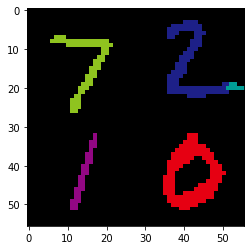

In [20]:
plot_image(main_net, td)

In [21]:
def distillation_layer(layer):
    if layer['type'] != 'convolution':
        return False
    
    if layer['lut_size'] == 2:
        ref_affine  = layer['ref_affine']
        target_lut0 = layer['target_lut0']
        target_lut1 = layer['target_lut1']

        tensorW = layer['ref_affine'].W()
        W = np.array(tensorW.get_data()).reshape(tensorW.get_shape()[::-1])
        idx = np.argsort(-np.abs(W), axis=1)
        
        print(idx.shape)
        
        # Weight順で接続
        lut0_input_node_size  = target_lut0.get_input_node_size()
        lut0_output_node_size = target_lut0.get_output_node_size()
        for i in range(lut0_output_node_size):
            for j in range(6):
                target_lut0.set_connection_index([i], j, (i*6+j) % lut0_input_node_size)

        lut1_input_node_size  = target_lut1.get_input_node_size()
        lut1_output_node_size = target_lut1.get_output_node_size()
        for i in range(lut0_output_node_size):
            for j in range(6):
                for k in range(6):
                    target_lut1.set_connection_index([i*6+j], k, idx[i][(j*6+k) % lut1_input_node_size])
    
    layer['select'] = 'target'
    return True

0
1
(32, 9)
2
(32, 288)
3
(32, 288)
4
(32, 288)
5
(32, 288)
6
(32, 288)
7
(32, 288)
8
(32, 288)
9
(32, 288)
10
(32, 288)
11
(32, 288)
12
(32, 288)
13
(32, 288)
14
(32, 288)
15
(32, 288)
16
(32, 288)
17
(32, 288)
18
(32, 288)
19
(32, 288)
20
(32, 288)
21
(32, 288)
22
(32, 288)
23
(32, 288)
24
(32, 288)
25
(32, 288)
26
(32, 288)
27
(32, 288)


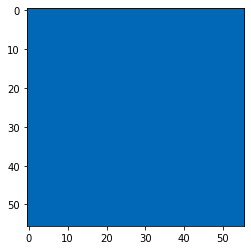

----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {56, 56, 1}   output shape : {56, 56, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {56, 56, 1}   output shape : {56, 56, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {56, 56, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {192}
       binary : 1       batch_norm : 1
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {192}       output shape : {32}
       

epoch=1 test_accuracy=0.954869 test_loss=4972.018711 train_accuracy=0.953665 train_loss=4974.155251


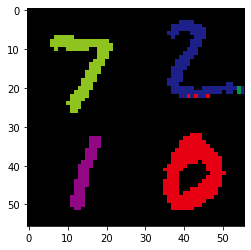

epoch=1 test_accuracy=0.952692 test_loss=4990.955874 train_accuracy=0.951570 train_loss=4992.877148


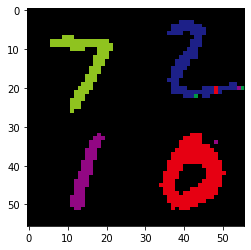

epoch=1 test_accuracy=0.954208 test_loss=4973.387919 train_accuracy=0.953159 train_loss=4975.247034


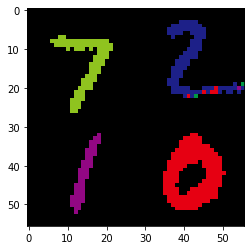

KeyboardInterrupt: 

In [22]:
# train
if True:
    for i in range(len(layer_list)):
        print(i)
        if distillation_layer(layer_list[i]):
            loaded = load_all_model('%03d' % i)
            if not loaded: 
#           if True:
                # 追加分
                main_net = build_net(layer_list)
                main_net.set_input_shape(td['x_shape'])
                main_net.send_command('binary true')
                
                plot_image(main_net, td)
                    
                main_net.send_command('parameter_lock true')
                layer_list[i]['target'].send_command('parameter_lock false')
                
                print(main_net.get_info())

                loss      = bb.LossSoftmaxCrossEntropy.create()
                metrics   = bb.MetricsCategoricalAccuracy.create()
                optimizer = bb.OptimizerAdam.create()
                optimizer.set_variables(main_net.get_parameters(), main_net.get_gradients())
                
                for _ in range(4):
                    runner = bb.Runner(main_net, network_name, loss, metrics, optimizer)
                    runner.fitting(td, epoch_size=1, mini_batch_size=32, file_write=False, file_read=False)

                    save_all_model('%03d' % i)

                    plot_image(main_net, td)
                
                # all
                if True:
                    main_net.send_command('parameter_lock false')

                    loss      = bb.LossSoftmaxCrossEntropy.create()
                    metrics   = bb.MetricsCategoricalAccuracy.create()
                    optimizer = bb.OptimizerAdam.create()
                    optimizer.set_variables(main_net.get_parameters(), main_net.get_gradients())
                    
                    for _ in range(4):
                        runner = bb.Runner(main_net, network_name, loss, metrics, optimizer)
                        runner.fitting(td, epoch_size=1, mini_batch_size=32, file_write=False, file_read=False)

                        save_all_model('%03d_f' % i)

                        plot_image(main_net, td)

In [ ]:
save_all_model()

In [ ]:
main_net = build_net(layer_list)
main_net.set_input_shape(td['x_shape'])
main_net.send_command('binary true')
main_net.send_command('parameter_lock false')
                
loss      = bb.LossSoftmaxCrossEntropy.create()
metrics   = bb.MetricsCategoricalAccuracy.create()
optimizer = bb.OptimizerAdam.create()
optimizer.set_variables(main_net.get_parameters(), main_net.get_gradients())

runner = bb.Runner(main_net, network_name, loss, metrics, optimizer)
runner.fitting(td, epoch_size=2, mini_batch_size=8, file_write=False, file_read=False)


In [ ]:
save_all_model('refine1')

In [ ]:
plot_image(main_net, td)